本笔记由马景义, 赖楸鸿完成, 如有任何错误欢迎向两位编者反馈.

## 一些常用的公式

（1）链式法则：若$y(x)$为$x$的向量函数，则
$$ \frac{\partial f(y(x))}{\partial x} = \frac{\partial y^T(x)}{\partial x}\frac{\partial f(y)}{\partial y} ,$$
其中$\frac{\partial y^T(x)}{\partial x}$为$n\times n$矩阵。

（2）$a$为$n\times1$常数向量，则
$$\frac{\partial a^Tx}{\partial x}= a ,$$
$$\frac{\partial x^Ta}{\partial x}= a.$$

（3）$a$为$n\times1$常数向量，则
$$\frac{\partial a^Ty(x)}{\partial x}=\frac{\partial y^T(x)}{\partial x}a ,$$
$$\frac{\partial y^T(x)a}{\partial x}=\frac{\partial y^T(x)}{\partial x}a.$$

（4）矩阵$A$和向量$y$与$x$无关，则$$\frac{\partial x^TAy}{\partial x}=Ay ,$$
$$\frac{\partial y^TAx}{\partial x}= A^Ty.$$

（5）矩阵$A$和向量$y$与$x$无关，则
$$\frac{\partial x^TA}{\partial x}=A ,$$
$$\frac{\partial x^TAx}{\partial x}=Ax+A^Tx=(A+A^T)x.$$

链式法则搭配后面四条可以衍生出许多公式，感觉已经非常够用了~

## 岭回归的求导部分

$$
L(\beta)=(Y-X\beta)^T(Y-X\beta)+\beta^T\lambda\beta ,$$
其中$Y$为$n\times1$向量，$X$为$n\times p+1$矩阵，$\beta$为$p+1\times1$向量，$\lambda$为$p+1\times p+1$矩阵,即
$$\lambda= \left[\begin{matrix}0 &0&\cdots&0 \\ 0&\lambda&\cdots&0\\ \vdots&\vdots&\ddots&\vdots\\0&0&\cdots&\lambda \end{matrix}\right].$$


$$
\begin{split}
&\frac{\partial L(\beta)}{\partial \beta} \\
=&\frac{\partial (Y-X\beta)^T(Y-X\beta)}{\partial \beta}+\frac{\partial \beta^T\lambda\beta}{\partial \beta} \\
=&\frac{\partial (Y-X\beta)^T}{\partial \beta}[(Y-X\beta)+(Y-X\beta)]+(\lambda+\lambda^T)\beta \\
=&-2X^T(Y-X\beta)+2\lambda\beta
\end{split}
$$


In [4]:
###mchol函数将方阵分解为一个下三角矩阵乘以该矩阵转置的形式,函数返回值为下三角矩阵
mchol <- function(x)
{
  #求矩阵x的行列数,m为行数,n为列数
  mn <- dim(x)
  m <- mn[1]
  n <- mn[2]

  #检验x是否为方阵
  if(m != n) 
  {
    return ("Wrong dimensions of matrix!")
  }

  #检验x是否为对称矩阵
  if(sum(t(x) != x) > 0) 
  {
    return ("Input matrix is not symmetrical!")
  }

  #L为与x行列数相等的方阵
  L <- matrix(0, m, m)
  
  #循环每进行一次,x的维度降低一维
  for(i in 1:m)
  {
    #L的对角线上元素为x的对角线上元素开方
    L[i,i] <- sqrt(x[i,i])
    if(i < m)
    {
      #求当前矩阵的第一列
      L[(i+1):m,i] <- x[(i+1):m,i]/L[i,i]

      #将刚才求出的第一列乘以它的转置得到TLM(为什么不能直接写TLM = TLV %*% t(TLV)?)
      TLV <- L[(i+1):m,i]
      TLM <- matrix(TLV, m-i, m-i)
      TLM <- sweep(TLM, 2, TLV, "*")

      #降维后的矩阵为原来位置上的元素减去TLM
      x[(i+1):m,(i+1):m] <- x[(i+1):m,(i+1):m] - TLM
    }
  }
  #矩阵的返回值为我们要求的下三角矩阵L
  L  
}

######EXAM
#y=matrix(rnorm(20),5)
#x=t(y)%*%y
#mchol(x)
######EXAM

In [5]:
###mforwardsolve函数的参数为一个下三角矩阵L和它与另一个矩阵的乘积得到的向量结果b,返回值为另一个矩阵x
mforwardsolve <- function(L, b)
{
  #求L的行列数,m为L的行数,n为L的列数
  mn <- dim(L)
  m <- mn[1]
  n <- mn[2]

  #判断L是否为方阵
  if(m != n) 
  {
    return ("Wrong dimensions of matrix L!")
  }
  
  #判断L是否为下三角矩阵
  for (i in 1:(m-1))
  {
    if(sum(L[i,(i+1):m] != 0) > 0)
    {
      return ("Wrong dimensions of matrix L不是下三角!")
    }
  }

  #判断L的行数与b的列数是否相等
  if(m != length(b))
  {
    return ("Wrong dimensions of matrix L or vector b!")
  }
  
  x=rep(0, m)
  
  #循环每进行一次,b的维度降低一维(减少第1行和第1列)
  for(i in 1:m)
  {
    #求当前循环中x的第一个元素
    x[i] <- b[i] / L[i,i]
    #降维后的向量为原来位置上的元素减去刚才求出的x元素下三角矩阵当前的第一列的乘积
    if(i < m) 
    {
      b[(i+1):m] <- b[(i+1):m] - x[i]*L[(i+1):m,i]
    }      
  }
  #函数返回值为x向量
  x  
}



###mbacksolve函数与上一个函数所需参数,输出结果大致相同,但L为一个上三角矩阵
mbacksolve <- function(L, b)
{
  #求L的行列数,m为L的行数,n为L的列数
  mn <-dim(L)
  m <- mn[1]
  n <- mn[2]

  #判断L是否为方阵
  if(m != n)
  {  
    return ("Wrong dimensions of matrix L!")
  }

  #判断L是否为上三角矩阵
  for (i in 2:m)
  {
    if(sum(L[i,1:(i-1)] != 0) > 0)
    {
      return ("Wrong dimensions of matrix L不是下三角!")
    }
  }

  #判断L的行数与b的列数是否相等
  if(m != length(b))
  {
    return ("Wrong dimensions of matrix L or vector b!")
  }  
  
  x <- rep(0, m)
  
  #循环每进行一次,b的维度降低一维(减少最后1行和最后1列)
  for(i in m:1)
  {
    #求当前循环中x的最后一个元素
    x[i] <- b[i] / L[i,i]
    #降维后的向量为原来位置上的元素减去刚才求出的x元素与上三角矩阵当前的最后一列的乘积
    if(i > 1) 
    {
      b[(i-1):1] <- b[(i-1):1] - x[i]*L[(i-1):1,i]
    }      
  }
  #函数返回值为x向量
  x  
}


######EXAM
#y=matrix(rnorm(20),5)
#x=t(y)%*%y
#L=mchol(x); b=1:4
#mforwardsolve(L,b)
#forwardsolve(L,b)
######EXAM

In [6]:
###ridgereg函数的参数x和y分别为回归方程的自变量和因变量,猜测lambda在表示参数被缩小或放大的比例,返回值为参数

ridgereg <- function(lambda, x, y)
{
  #y=data[,m]; x=data[,-m]
  #n为自变量矩阵行数,即n个样本,p为自变量矩阵列数,即p个参数
  np <- dim(x)
  n <- np[1]
  p <- np[2]

  #将自变量矩阵增加一列,以便于截距项的计算
  x <- as.matrix(cbind(rep(1, n),x))

  #利用乔里斯基分解求取回归方程的参数
  V <- t(x)%*%x + diag(c(0, rep(lambda, p)))
  U <- as.vector(t(x)%*%y)
  R <- mchol(V)
  M <- mforwardsolve(R, U)
  mbacksolve(t(R), M)   
}

In [3]:
outer(2:4,2:4)

4,6,8
6,9,12
8,12,16


[1]  0.439533558  0.562800409  0.561761682 -0.019871001  0.098950295
[6]  0.645197525 -0.077754860  0.034427977  0.004655636

lpsa
0.562800409
0.561761682
-0.019871001
0.098950295
0.645197525
-0.077754860
0.034427977
0.004655636


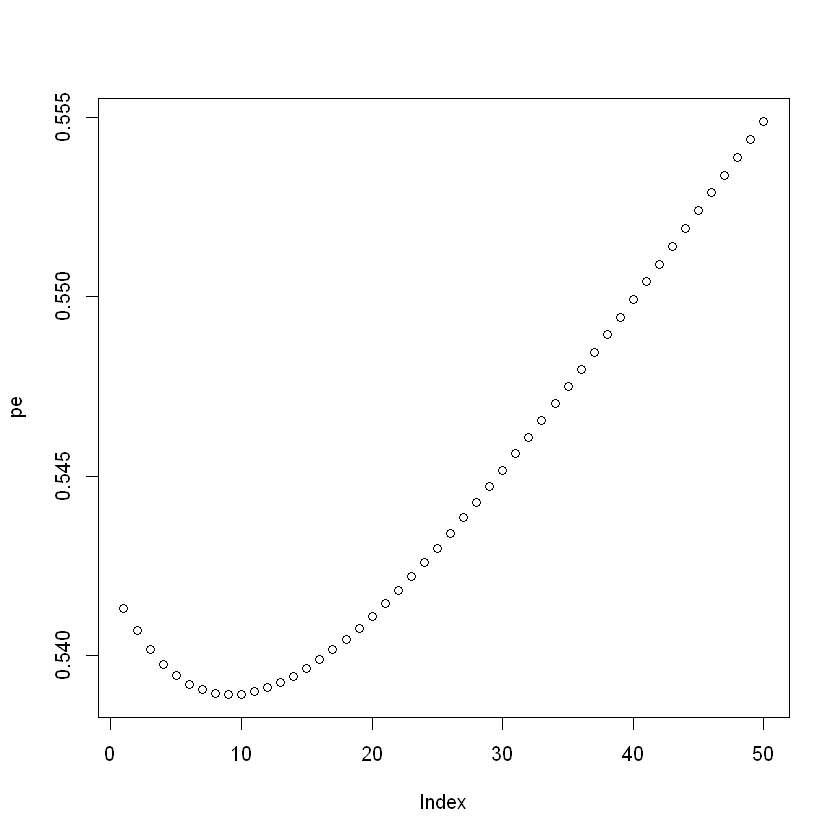

In [27]:
###pred函数的参数b为参数向量,x为自变量,返回值为因变量的预测值
pred <- function(b, nx)
{
  #nx=prostate[1:2,1:8]
  b <- as.vector(b)
  p <- length(b) - 1
  
  #为什么此处要将矩阵重新排列,原本的形式在计算预测值时不就可以直接与参数向量相乘,不用转置了吗?
  nx <- as.matrix(nx, ncol <- p)
  n <- dim(nx)[1]
  
  #计算预测值
  apply(t(nx)*b[2:(p+1)], 2, sum) + b[1]  
}



###cvridgeregerr的参数依次为参数调整比例,自变量,因变量,返回值为bias(每次删掉一行样本,计算n个模型)
cvridgeregerr <- function(lambda, x, y){ 
    #mrige函数每次删掉一组样本进行回归,最后得到n个模型的参数 
    np <- dim(x)
    n <- np[1]
    p <- np[2]
    
    x <- cbind(1,x)
    xy <- cbind(x,y)
    
    xtx=t(x)%*%x + diag(c(0, rep(lambda, p)))
    xty=t(x)%*%y
        
    mridge <- function(ixy, lambda, xtx, xty){
        mp=length(ixy)
        ix <- ixy[-mp] 
        iy <- ixy[mp]
        ixtx <- xtx - outer(ix,ix)
        ixty <- xty - iy*ix
        R <- mchol(ixtx)
        M <- mforwardsolve(R, ixty)
        mbacksolve(t(R), M)
    }

    #n为自变量矩阵行数,即n个样本,p为自变量矩阵列数,即p个参数
    
    #依次删掉第1至n行样本,利用ridgereg函数得到n个模型的回归参数
    coe <- t(apply(xy, 1, mridge, lambda, xtx, xty))
    
    #计算n个模型的预测值与真实值的距离,再计算这n个距离的平均值(我觉得这里应该是cbind(1, x)*coe) 
    mean((apply(coe*x, 1, sum) - y)^2)
}



###ridgeregerr的参数依次为参数调整比例,自变量,因变量,返回值为bias(只计算一个模型)
ridgeregerr <- function(lambda, x, y)
{
  #先利用ridgereg函数回归参数,再输入pred函数求取预测值,最后计算n组样本预测值与真实值距离的平均值
  mean((pred(ridgereg(lambda, x, y), x) - y)^2)
}




###############################
###在不同的调整参数的比例下,比较两种回归方式的bias
library(ElemStatLearn)
x <- as.matrix(prostate[ ,1:8])
y <- as.vector(prostate[ ,9])
LAM <- seq(0.001, 10, len=50)
err <- unlist(lapply(LAM, ridgeregerr, x, y))
pe <- unlist(lapply(LAM, cvridgeregerr, x, y))
#x <- rep(1:50, 2)
plot(pe)
lam=LAM[which.min(pe)]


###############################################
###比较两个回归模型,另一个应该是岭回归
library(ElemStatLearn)
x <- prostate[ ,1:8]
y <- prostate[ ,9]
ridgereg(lam, x, y)
library(mda)
ridge1 <- gen.ridge(prostate[ ,1:8], prostate[ ,9, drop <- FALSE], lambda =lam)  
ridge1$coe